# Connected and Autonomous Driving - Visual Perception Module
Lab credits: [François Robinet](mailto:francois.robinet@uni.lu)

----

This assignement is separated in 3 parts related to visual percepetion:
- In the first, you will learn about creating an image classification model from nothing.
- In the second, you will use and fine-tune a detection model.
- In the third, you will learn how to use this model in a simulation environment.

In this assignment, we will learn how to tackle the complex problem of classifying traffic signs. These signs come in many shapes, colors and forms, and it is hard even for us to express how exactly we identify traffic signs. This makes learning from actual data an ideal fit for this problem!

The following concepts will be covered in this Lab:

1. Loading data in a format suitable for learning algorithms
1. Implementation of a Softmax Classifier in plain PyTorch
1. Performance assessment in machine learning
1. GPU Implementation of complex classification models using PyTorch
1. Regularization in the context of neural networks (data augmentation, dropout, early stopping)
1. Fine-tuning a pre-trained detection model to fit an application

In this lab, we will leverage the GPU capabilities of Google Colab. To enable a GPU for this notebook, go to "Execution > Change Execution Type" and add GPU capabilities. Executing the next cell should succeed and show one available GPU.


In [1]:
! nvidia-smi

Sun Dec  7 13:06:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Loading Traffic Sign Data

You will find the traffic sign dataset used for this assignment `traffic_signs.zip` in the git page of this project.

download the corresponding zip file and upload it to the repository of this google collab, then run the following cell.

In [2]:
from pathlib import Path

FILENAME=Path("/content/traffic_signs.zip")
traffic_signs_dir = Path("/content/datasets/traffic_signs_data")
traffic_signs_dir.mkdir(parents=True, exist_ok=True)
print(f"Extracting the traffic sign dataset")
! unzip -q {FILENAME} -d {traffic_signs_dir}

Extracting the traffic sign dataset


The traffic sign data is split into train / validation / test datasets.
Each of this dataset has can be loaded directly using `numpy.load`.

The data contains the following data for the traffic signs:

- `features`: the traffic sign 32x32 3-channel RGB images
- `labels`: a single label for each sample, represented as a number in [0,42]. These numbers relate to each of the 43 traffic signs names that are read from  `signnames.csv`.

Let's load the 34799 samples of the training set and display a 16 random images with their labels.


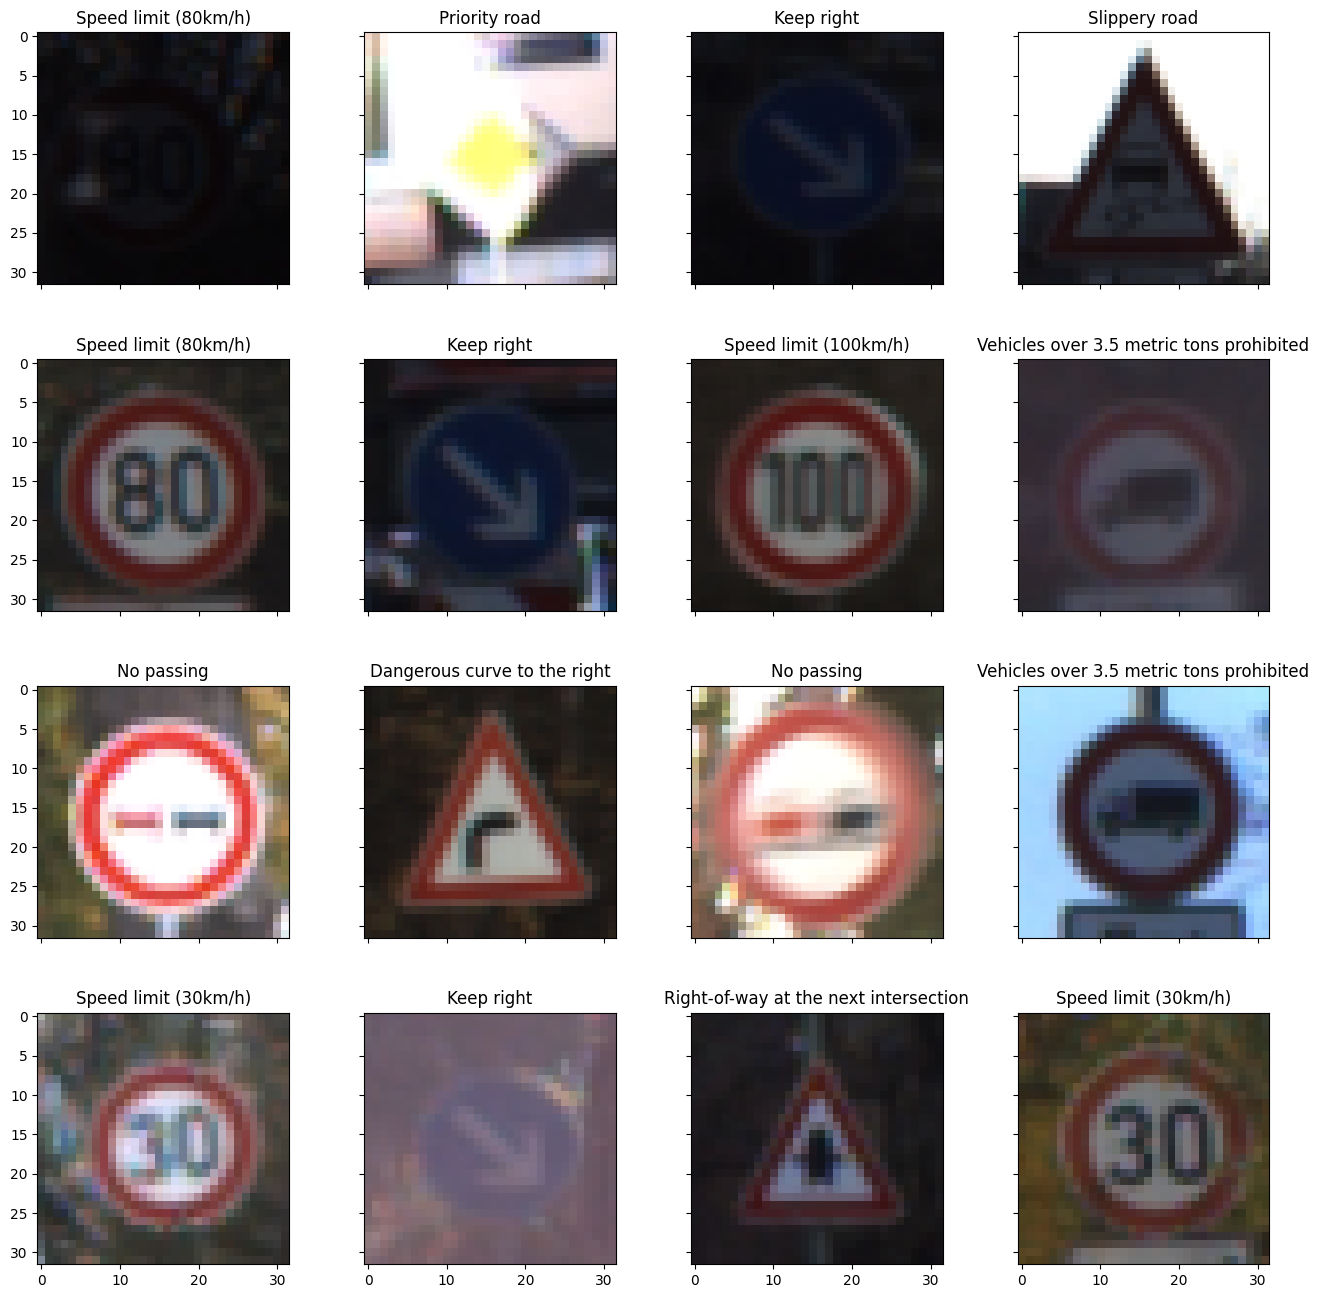

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def load_data(path):
  data = np.load(path, allow_pickle=True)
  images, labels = data["features"], data["labels"]
  # Pixels are stored as unsigned integers in [0,255]
  # Because our numerical operations treat these as floating point numbers,
  # it's best to convert these numbers to float and map them to [0,1]
  images = images.astype(np.float32) / 255.0
  labels = labels.astype(np.int64)
  return images, labels

def show_image_grid(images, titles):
  fig = plt.figure(figsize=(16,16))
  ncols = 4
  nrows = int(np.ceil(images.shape[0] // ncols))
  grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.75)
  for ax, img, title in zip(grid, images, titles):
    ax.imshow(img)
    ax.set_title(title)

# Read data
sign_names = pd.read_csv(traffic_signs_dir / "signnames.csv").SignName.values
training_images, training_labels = load_data(traffic_signs_dir / "train.p")
training_size = training_labels.shape[0]

# Display 16 random images with their labels
random_indices = np.random.choice(np.arange(training_size), size=16, replace=False)
show_image_grid(training_images[random_indices], sign_names[training_labels[random_indices]])


## Classification with a Single Layer: Logistic/Softmax Regression

### Model

Our first approach will be to implement a simple linear classifier using numpy only. This means that our output will be predicted as

$$\hat{y} = \sigma(Wx+b)$$

where

- $x$ is a vector image pixel values. Shape is $(3*32*32,) = (3072,)$.
- $\hat{y}$ is a $(43,)$ shaped vector containing a probability value for each class.
- $W$ is a (43,3072) matrix of weights to be learned. The weights will be initialized to random numbers in $[0,1]$. More advanced strategies exist and will be covered in the next parts.
- $b$ is a vector of weights called the biases, that will also be learned. Its shape is $(43,)$
- $\sigma$ is the softmax activation function which will project values in $Wx$ into $[0,1]$ and make them sum to one: $\sigma(x)_i = \frac{e^{x_i}}{\sum_je^{x_j}}$.



### From Theory to Practice: Implementing the model

Let's now implement our softmax classifier in PyTorch. We can easily do so by creating a new class deriving from `torch.nn.Module` and implementing the computation in its `forward` method. You'll learn more about why this is called `forward` next week.

If you want to show the documentation relative to a function like `torch.nn.Parameter`, just execute the following code in a cell and documentation will pop-up.

```
torch.nn.Parameter?
```


In [4]:
import torch
from torch import nn
import torch.nn.functional as F

class SoftmaxClassifier(nn.Module):
  def __init__(self):
    super().__init__() # Mandatory: PyTorch does some setting up in there!
    # Create our weight Tensor W. It will be of type float and have shape (1,43,3*32*32)
    # The extra first dimension is there because nn.Modules are meant to process
    # batches of inputs, and the inputs after reshaping will have shape (B, 3072, 1),
    # where B is the batch size. Adding an extra dimension is needed for numpy
    # to broadcast the first dimension of our weights to B.
    W_shape = (1, 43, 3072) # TODO
    bias_shape = (1, 43, 1) # TODO ---
    # Since we want to learn these weights, we will create them as "parameters" (another name for weights)
    # Initialize parameters with random numbers in [0,1] (biases can be initialized to zero)
    # Better init stategies exist and will be covered later on
    self.W = nn.Parameter(torch.Tensor(*W_shape))
    nn.init.uniform_(self.W, 0.0, 1.0)
    self.bias = nn.Parameter(torch.zeros(bias_shape))

  def forward(self, x):
    # The formula treats x as a vector, but we're receiving a batch of images
    # with shape (B,32,32,3), which we reshape to (B,32*32*3,1).
    x = x.view(x.shape[0],-1,1)
    # TODO: Compute our prediction y_hat following the formula in the description above
    # Hint: the softmax function is available as torch.nn.functional.softmax (here F.softmax)
    # Keep in mind that you want to compute the softmax separately on each image,
    # so no softmax on dim 0!
    logits = torch.matmul(self.W, x) + self.bias # ---
    y_hat = F.softmax(logits, dim=1) # TODO ---
    return torch.squeeze(y_hat) # Squeeze removes any extra dimension with value 1, so we're back to (B,43) shape

# Create our classifier
softmax_classifier = SoftmaxClassifier()

### Our very first prediction

We have a randomly intialized model, let's use it to make a prediction on a random batch of images!

Remember that we are predicting 43 numbers for each image, which according to our model can be interpreted as the probability of each class to be the "right one". To get an actual prediction, we can simply grab the class with maximal probability.

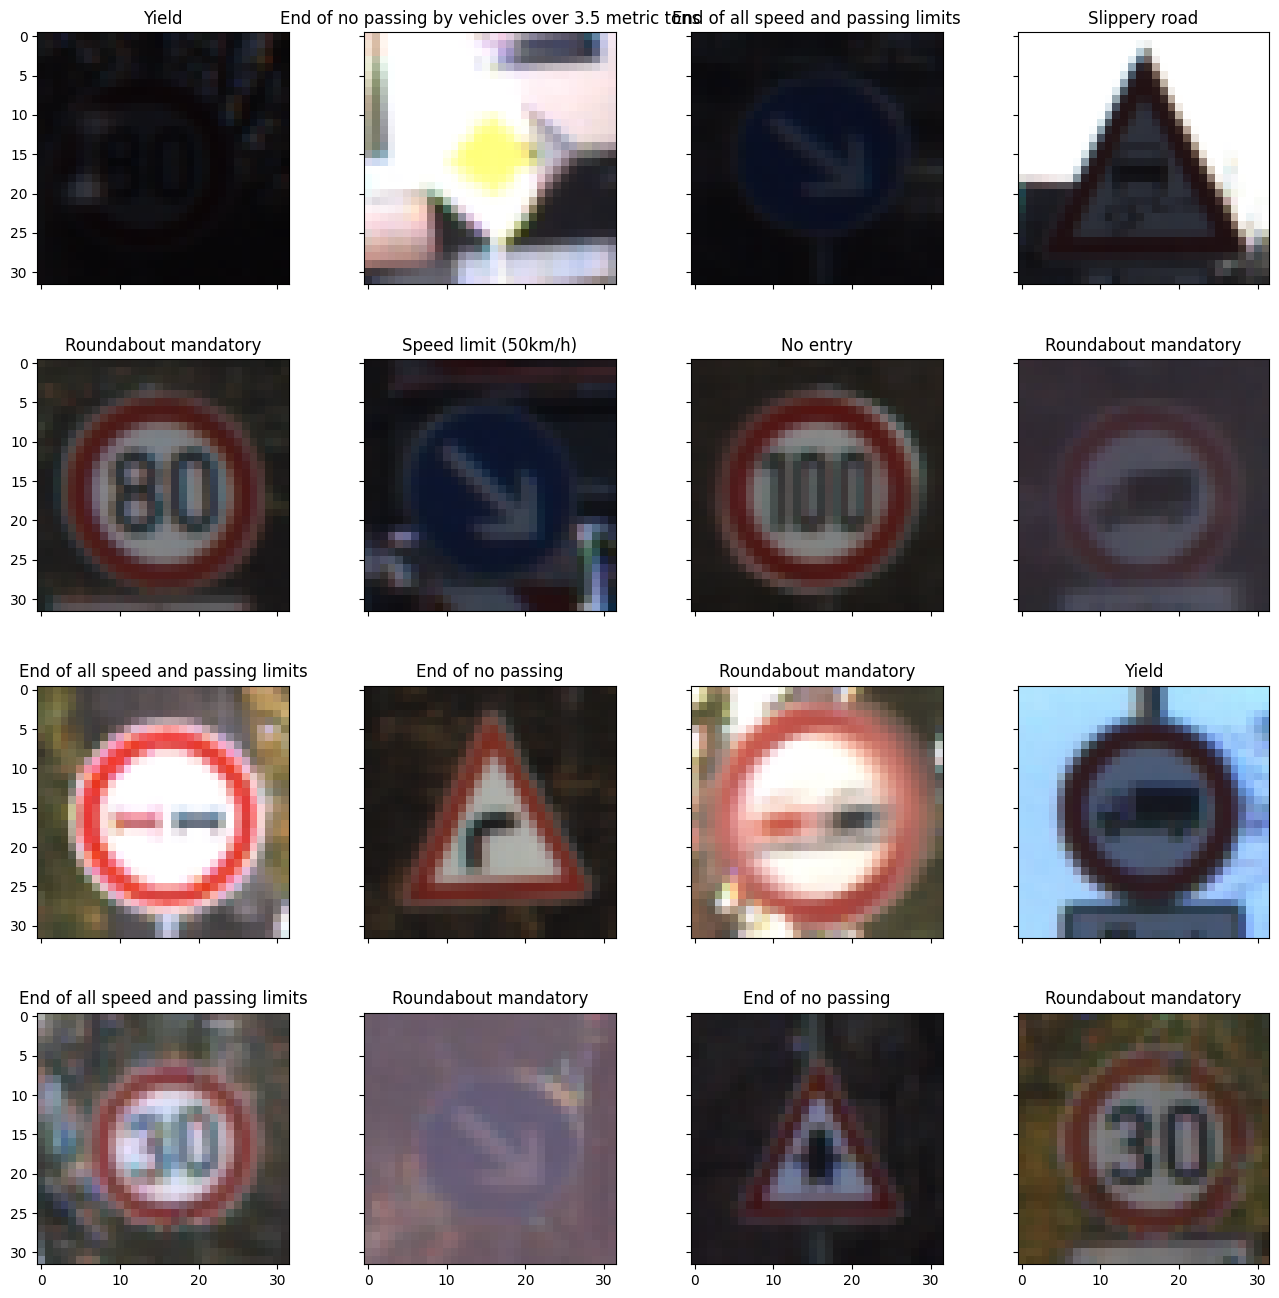

In [5]:
# We will reuse the random batch of 16 images we showed when loading the data
input_images = torch.from_numpy(training_images[random_indices]) # This has shape (16,32,32,3)
with torch.no_grad(): # Don't worry about no_grad for now, it just means we're not trying to optimize anything
  # TODO: Compute class probabilities by feeding the random_batch to your model (just a function call like "model(x)")
  y_pred = softmax_classifier(input_images.float()) # Class probabilities ---
  assert y_pred.shape == (input_images.shape[0],sign_names.shape[0]), f"Predicted shape should be {(input_images.shape[0],sign_names.shape[0])} and is {y_pred.shape}."

# TODO: Find the most probable label for each image according to our model
# Hint: torch.argmax should help you there, just keep in mind that you want the max *per-image* (so don't argmax on dimension 0)
predicted_labels = torch.argmax(y_pred, dim=1) # Most probable label for each image ---
assert predicted_labels.shape == (input_images.shape[0],), f"Predicted labels shape should be {(input_images.shape[0],)} and is {(input_images.shape[0],)}"
predicted_sign_names = sign_names[predicted_labels.cpu().numpy()] #---

# Show the image and their predicted class
show_image_grid(input_images, predicted_sign_names)

### Training our Model

Our first prediction is rather... disappointing. It's not surprising though: we've learned a lot, but our model hasn't and it's predicting at random, often choosing the same class for most inputs! Let's see if we can fix this!

#### Loss Function

We first transform each ground truth label into a one-hot encoded vector

$$
\begin{equation}
  y_i=\begin{cases}
    1 & \text{if sample has class } i\\
    0 & \text{otherwise}.
  \end{cases}
\end{equation}
$$

We want to make $\hat{y}$ close to the ground truth $y$, which can be done in several ways. For multinomial classification, it is very common to use the "Negative Log-Likelihood Loss" we covered in class. In PyTorch, this loss function $L(y,\hat{y})$ is implemented in `torch.nn.NLLLoss`.


#### Stochastic Gradient Descent

Stochastic Gradient Descent iteratively updates the weights in order to minimize $L(\hat{y},y)$. Remember that $L$ depends on the weights because each prediction $\hat{y} = \sigma(Wx+b)$ depends on them.

We seek to compute the optimal weights $W^*$ such that

$$W^* = \underset{W,b}{\mathrm{argmin}}\ L(\sigma(Wx+b),y)$$

Gradient-based optimization iteratively improves on weight estimates $(W_k, W_{k+1}, ...)$ and $(b_k, b_{k+1}, ...)$ by making steps in the direction opposite to the gradient/jacobian directions

\begin{equation}
\begin{cases}
    W_{k+1} &= W_k - \alpha \nabla_W L\\
    b_{k+1} &= b_k - \alpha \nabla_b L
\end{cases}
\end{equation}

Where $\alpha$ defines a "step size", usually refered to as "learning rate" in machine learning. There are also more fancy ways to update parameters at each iteration, and we will discuss these in later classes.

Computing $\nabla_W L$ and $\nabla_b L$ is not trivial and will be covered in later classes.
One of the primary reasons for using Deep Learning frameworks like PyTorch or Tensorflow is that they will compute these for us!


  0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, 'Training Loss')

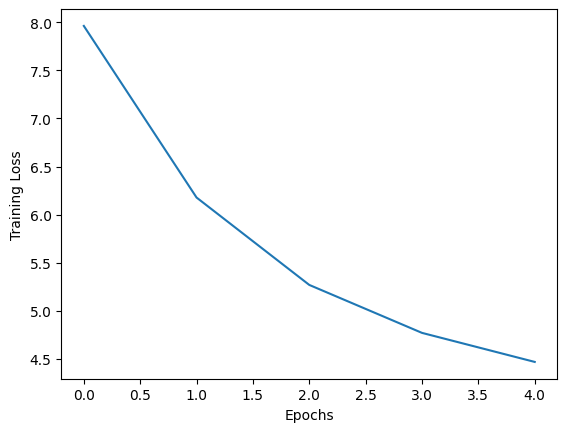

In [6]:
from tqdm.notebook import tqdm # We'll use this for nice progress bars

# Training Loop:
#   - separate the training data into batches of 64 samples
#   - each epoch goes over all the batches in the dataset, and we can repeat the process for many epochs
#   - we feed each batch to our model, compute a loss, compute its gradient, and perform an SGD update
batch_size = 256
num_epochs = 5
learning_rate = 5e-3
batches_per_epoch = int(np.ceil(training_images.shape[0] / batch_size))
loss_function = torch.nn.NLLLoss() # Negative Log-Likelihood loss function (aka cross-entropy loss)

softmax_classifier = SoftmaxClassifier()
softmax_classifier.train()
epoch_losses = []
pbar = tqdm(range(num_epochs))
for epoch in pbar:
  average_epoch_loss = 0 # Running average loss over epoch
  for batch_idx in range(batches_per_epoch):
    # Get batch of training data
    batch_start_index = batch_size * batch_idx
    batch_images = torch.from_numpy(training_images[batch_start_index:batch_start_index+batch_size]).float() #---
    batch_labels = torch.from_numpy(training_labels[batch_start_index:batch_start_index+batch_size]).long()  #---

    # TODO: Feed images to the model
    class_probabilities = softmax_classifier(batch_images)

    # Compute loss value using NLLLoss
    # NLLLoss expects log-probabilities rather than probabilities
    # NLLLoss will also handle converting ground truth labels to one-hot encoded vectors
    class_log_probabilities = torch.log(class_probabilities+1e-7) # 1e-7 added for numerical stability
    loss = loss_function(class_log_probabilities, batch_labels)

    # Print loss information so we can monitor training
    average_epoch_loss = (batch_idx * average_epoch_loss + loss.item()) / (batch_idx+1)

    # Compute the gradient of the loss wrt. to model parameters
    loss.backward() # The reason why this is called "backward" will become clear after the next class

    # TODO: Implement SGD update
    # After the call to loss.backward, the gradient of the loss with respect to parameter w is `w.grad`
    # You can access all the model's parameters with `softmax_classifier.parameters()` and loop over them to update them
    with torch.no_grad(): # Loop wrapped in no_grad again because we don't need to accumulate gradients for this step
      for p in softmax_classifier.parameters():
        p -= learning_rate * p.grad # TODO SGD Update ---
        # *important*: by default PyTorch remembers gradients from previous iterations, so we always have to zero them out before next iteration
        p.grad.zero_()
  epoch_losses.append(average_epoch_loss)
  pbar.set_description(f"Last Epoch Loss: {average_epoch_loss:.4f}")

# Plot training loss evolution
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

### CUDA to the Rescue

Our model is learning, but it's pretty slow, taking upward of 15s for each epoch. We can speed this up tremendously by leveraging the GPU. Indeed, Matrix multiplication is at the heart of our model, and is the type of heavily parallelizable operation that GPUs are extremely efficient at.

PyTorch makes moving this kind of computation to the GPU extremely easy. Modify the above code cell to

- Move your model to GPU memory: `softmax_classifier = SoftmaxClassifier().cuda()`
- Move your inputs to GPU memory: `batch_images = batch_images.cuda()`, `batch_labels = batch_labels.cuda()`
- Crank up the number of epochs: `num_epochs = 100`

To bring a GPU Tensor back to CPU RAM, we can simply use `tensor.cpu()`.

Run again, and enjoy the free speedup!

## Assessing Multinomial Classification Models

### Why bother with a test set?

The training loss informs us that the model is training, but it does not give us much information about the inference performance of that model. Indeed training metrics have no value when assessing generalization performance. To covince yourself of that fact, imagine a model that simply memorizes the training set entirely. This model is trivial to implement, it will have 0 training loss, but will be utterly useless to make predictions on unseen data!

To assess the generalization abilities, one should use a separate split of the data called the test set. This split of the data must never be used during training, and can only be used after the fact in order to estimate the performance of the trained model on unseen data. As much as possible, this test set should be representative of the data that would be encountered in the real-world application. This is also true for the training set of course!

Let's start assessing our model by computing the simplest classification metric: accuracy!

In [7]:
# Load the test data
from sklearn.metrics import accuracy_score
from typing import Dict, Callable
from tqdm.notebook import tqdm

def eval_metrics(model, dataset_images, dataset_labels, batch_size, metrics_fns: Dict[str,Callable], desc=None):
  model.eval()
  total_batches = int(np.ceil(dataset_images.shape[0] / batch_size))
  device = next(model.parameters()).device #---

  with torch.no_grad():
    pred_labels = []; true_labels = []
    for batch_idx in tqdm(range(total_batches), desc=desc):
      batch_start_index = batch_idx * batch_size
      batch_images = torch.from_numpy(dataset_images[batch_start_index:batch_start_index+batch_size]).float().to(device) #---
      batch_labels = torch.from_numpy(dataset_labels[batch_start_index:batch_start_index+batch_size]).long().to(device) #---

      class_probabilities = model(batch_images)
      predicted_labels = torch.argmax(class_probabilities, dim=1)
      pred_labels.append(predicted_labels.cpu().numpy())
      true_labels.append(batch_labels.cpu().numpy())

  pred_labels = np.hstack(pred_labels)
  true_labels = np.hstack(true_labels)
  return { name: metric(true_labels, pred_labels) for name, metric in metrics_fns.items() }

test_images, test_labels = load_data(traffic_signs_dir / "test.p")
training_metrics = eval_metrics(softmax_classifier, training_images, training_labels, 256, {"accuracy": accuracy_score}, desc="Training Eval")
test_metrics = eval_metrics(softmax_classifier, test_images, test_labels, 256, {"accuracy": accuracy_score}, desc="Test Eval")
print(f"Training metrics: {training_metrics}")
print(f"Test metrics: {test_metrics}")

Training Eval:   0%|          | 0/136 [00:00<?, ?it/s]

Test Eval:   0%|          | 0/50 [00:00<?, ?it/s]

Training metrics: {'accuracy': 0.07299060317825225}
Test metrics: {'accuracy': 0.05977830562153603}


### So, are we done yet?

You should observe a test set accuracy around 40%, and an even better  one for the training set. If the gap between the training and test set is large, this indicates overfitting and a need for regularization.

We should note that, while a test set accuracy of 40% is not great, it is also pretty impressive considering the simplicity of our model. With 43 classes, and a model predicting completely at random would only achieve $\frac{1}{43} \approx 2.5\%$ accuracy, so we have that going for us...

<img src="https://i.imgflip.com/4kb85r.jpg" align="center" />


### Multi-class Classification Metrics

The following cell shows a distribution of classes in the test set. As expected for traffic signs, the classes are heavily imbalanced: some categories are much more common than others.

If our goal is to be able to detect all traffic signs with the same precision, we should not look at plain accuracy results, but rather at metrics that take imbalance into account, such as the balanced accuracy. For details on other possible metrics, see [this survey](https://arxiv.org/pdf/2008.05756.pdf).


<Axes: ylabel='count'>

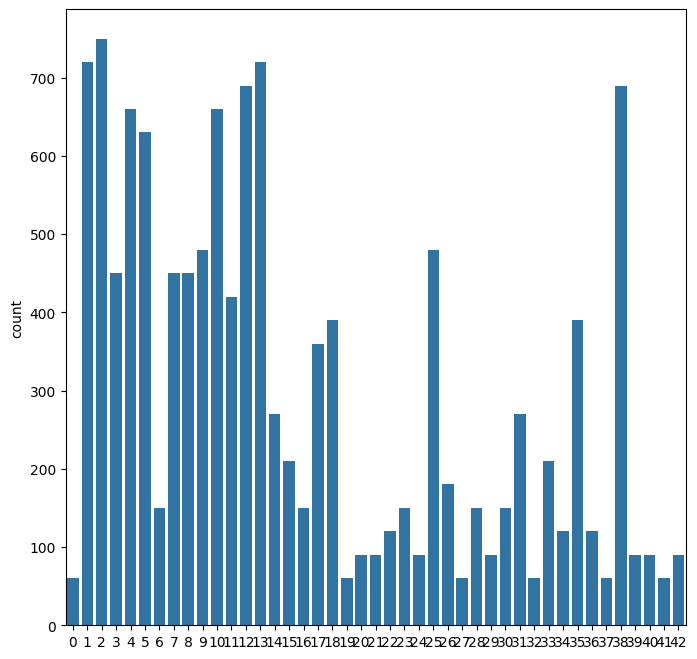

In [8]:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.countplot(x=test_labels)

In [9]:
# Balanced accuracy computation
from sklearn.metrics import accuracy_score, balanced_accuracy_score
metrics = {
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score
}
training_metrics = eval_metrics(softmax_classifier, training_images, training_labels, 256, metrics, desc="Training Eval")
test_metrics = eval_metrics(softmax_classifier, test_images, test_labels, 256, metrics, desc="Test Eval")
print(f"Training metrics: {training_metrics}")
print(f"Test metrics: {test_metrics}")

Training Eval:   0%|          | 0/136 [00:00<?, ?it/s]

Test Eval:   0%|          | 0/50 [00:00<?, ?it/s]

Training metrics: {'accuracy': 0.07299060317825225, 'balanced_accuracy': np.float64(0.04127166072289793)}
Test metrics: {'accuracy': 0.05977830562153603, 'balanced_accuracy': np.float64(0.03392775956021659)}


### What now?

They are two possibilities to go forward:

1. We trust in our current model, and we decide to fine-tune hyperparameters such as the batch size or the learning rate. This will require the use of a validation set to find optimal parameters.
2. We decide that a linear classifier acting directly on pixels is probably not that great of an idea to begin with, and we decide to go deeper!

Guess what, we'll go for option 2!

## Going Deeper: Multi-Layer Classifier

In this section, we'll redo much of the same work as for the single layer classification but, now that we know how things work under the hood, we'll rely a lot more on PyTorch to do things for us!

Our first model was nothing else than a softmax activation function stacked on top of a linear layer. The next one will exploit the same idea by stacking multiple layers on top.

The architecture will be as follows:

- Input $x$ of shape (B,32,32,3)
- Layer 1: Linear layer (aka fully-connected) with 100 neurons with biases, followed by ReLU activation ($32*32*3*100 + 100$ learnable weights)
- Layer 2: Linear layer with 75 neurons with biases, followed by ReLU activation ($100*75+75$ learnable weights)
- Output Layer: Linear layer with 43 neurons with biases followed by softmax activation ($75*43+43$ learnable weights)

Where $B$ is the batch size.




### PyTorch, batteries included

This time around, we will be using PyTorch's built-in layers, instead of creating them by hand like the first time. For reference, we could have simply implemented our previous model as:

```
softmax_classifier = nn.Sequential(nn.Flatten(), nn.Linear(32*32*3, 43), nn.Softmax())
```

We will also keep relying on the GPU for our model's computation using `.cuda()` to move tensor to the GPU.

Start the following cell to start training the model, and take your time to go over the code. There are no new concept, but this is now implemented using more of PyTorch's utilities.


In [10]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, balanced_accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# PyTorch has utilities for dealing with datasets that extend its Dataset class
# It will be able to automatically load in batches and in parallel.
# In this toy example, the whole dataset fits in memory, but in most application,
# the whole dataset can weight 100GB+, so loading it in parallel makes a big difference.
class TrafficSignsDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    images, labels = load_data(path)
    images = images.transpose((0,3,1,2)) # PyTorch expects image data in (channel,height,width) format instead of the usual (height,width,channel)
    self.images = torch.from_numpy(images).float().to(device) # --- # Send data to GPU memory
    self.labels = torch.from_numpy(labels).long().to(device)
  def __len__(self):
    return len(self.images)
  def __getitem__(self, idx):
    return self.images[idx], self.labels[idx]

# Training loop
batch_size = 256
training_dataset = TrafficSignsDataset(traffic_signs_dir / "train.p")
validation_dataset = TrafficSignsDataset(traffic_signs_dir / "valid.p")
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

def predict_batch(model, batch_images, no_grad: bool):
  if no_grad:
    with torch.no_grad():
      class_probs = model(batch_images)
  else:
      class_probs = model(batch_images)
  class_labels = torch.argmax(class_probs, dim=1)
  return class_probs, class_labels

def eval_metrics(pred_labels, true_labels, prefix):
    metrics = {
      f"{prefix}accuracy": accuracy_score,
      f"{prefix}balanced_accuracy": balanced_accuracy_score
    }
    return { name: metric_fn(true_labels,pred_labels) for name, metric_fn in metrics.items() }

def train_model(model, training_loader, validation_loader, num_epochs, learning_rate):
  # Loss, optimizer and metrics
  model.to(device) #---
  loss_function = torch.nn.NLLLoss() # Negative Log-Likelihood loss function
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # We'll use a built-in optimizer implementation this time
  pbar = tqdm(range(num_epochs),desc="Epochs")
  for epoch in pbar:
    # Training
    train_losses = []
    train_true_labels = []
    train_pred_labels = []
    for batch_idx, (batch_images, batch_labels) in enumerate(training_loader):
      # move batch to device
      batch_images = batch_images.to(device) #---
      batch_labels = batch_labels.to(device) #---

      # Loss computation
      class_probs, class_labels = predict_batch(model, batch_images, no_grad=False)
      class_log_probs = torch.log(class_probs+1e-7)
      loss = loss_function(class_log_probs, batch_labels)
      train_true_labels.append(batch_labels.cpu().numpy())
      train_pred_labels.append(class_labels.cpu().numpy())

      train_losses.append(loss.item())
      # SGD Step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # Evaluation
    # Because Google lets us use pretty big GPUs for free,
    # we can predict the whole validation set at once!
    # This if of course almost never possible on larger datasets and in practice
    # we'd have to use a validation dataloader like for the training set
    val_images = validation_dataset.images.to(device)
    _, val_class_labels = predict_batch(model, validation_dataset.images, no_grad=True)
    val_metrics = eval_metrics(
        val_class_labels.cpu().numpy(), # Send results GPU -> CPU memory
        validation_dataset.labels.cpu().numpy(),
        prefix="val_")
    train_metrics = eval_metrics(
        np.hstack(train_pred_labels),
        np.hstack(train_true_labels),
        prefix="train_")
    train_metrics["train_loss"] = np.mean(train_losses)
    pbar.set_postfix({**train_metrics, **val_metrics})

# Define the model
deep_softmax_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 100), nn.ReLU(),
    nn.Linear(100, 75), nn.ReLU(),
    nn.Linear(75, 43), nn.Softmax(dim=1),
).to(device) # Send model to GPU memory

# Start training
train_model(deep_softmax_classifier, training_loader, validation_loader, num_epochs=150, learning_rate=1e-2)

Using device: cuda


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

The validation accuracy should now be closer to 85%, which is a nice improvement! You're also probably observing a much higher training accuracy, which is a sign of overfitting!

Let's see if we can do even better if we stop considering all pixels independently: enter convolutions!

## Making things more Convoluted

Now that we are familiar with Linear layers, it's time to discover another type of layer: the extremely popular Convolutional Layer.

We will use these layers as a "feature extractor":

- Instead of using `Flatten` directly on the input pixels like we've done so far, these pixels will first be pre-processed by a few Conv layers, and we will flatten their output to a (B,512) vector
- The next layers will be the usual Linear layers, the only difference is that they don't operate on raw pixels anymore.

You can start out by adding 2 Linear layers and train the model. You should get very good training performance, but your model will likely overfit. Your job for assignment 1 will be to tweak both the architecture and the learning strategy in order to improve this.

In [11]:
# A typical CNN classifier
# We will discuss how this works in next week's class.
# For this assignment, use it as-is
# If you know Convolutional layers already, feel free to tweak it as much as you want
# but it's not necessary to complete the assignment!
feature_extractor = nn.Sequential(
    nn.Conv2d(3, 24, kernel_size=(6,6)), nn.ReLU(),
    nn.Conv2d(24, 36, kernel_size=(6,6)), nn.ReLU(),
    nn.Conv2d(36, 48, kernel_size=(4,4), stride=2), nn.ReLU(),
    nn.Conv2d(48, 64, kernel_size=(4,4), stride=2), nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(2,2), stride=2), nn.ReLU(),
)

conv_classifier = nn.Sequential(
    feature_extractor, # Extracts useful features
    nn.Flatten(), # Flatten all features into a single vector of dim (B,512)
    # TODO: Your layers go here ---
    nn.Linear(512, 100), nn.ReLU(),  # 1st Linear layer + ReLU
    nn.Linear(100, 43),         # 2nd Linear layer (output layer)
    nn.Softmax(dim=1),
).cuda() # Send model to GPU memory

# Start training
train_model(conv_classifier, training_loader, validation_loader, num_epochs=100, learning_rate=3e-2)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

## Assignment (Part One - Classification)

Your assignment is to build on the last model to further improve
performance. There are several ways you can improve what we have done so far:

- **Model Architecture**: Add more layers or remove some. If you're not familiar with Convolutional Layers, leave the feature extractor part untouched.
- **Regularization**: Early Stopping, Dropout layers, Batch Normalization, ...
- **Data Augmentation**: Dynamically modify training inputs in ways that don't change the output class that should be predicted, so that the classifier learns to deal with variations in the input. There are hundreds of ways to proceed, eg. by changing contrast, lightly blurring images, flipping them horizontally, taking crops, adding light noise on them, ... Be creative! A combination of search engine use and the `transform` module of the `torchvision` library might be very helpful for this. You can implement this in a flexible way by simply adding an `augment(x)` functiont that applies a random augmentation on a batch `x` and call it inside the training loop.
- **Hyperparameter Tuning**: Try to tweak the learning rate and batch size, using the validation set performance to guide your search. You can also experiment with the parameters of the SGD optimizer, or even try different optimizers altogether.

You should aim the best possible accuracy on the test set (95%+ is a good milestone). Of course, you should not use performance on the test set to tune your model, only the validation set. The test set should only be touched once you're satisfied of the performance of your model on the training and validation sets.

Once you're satisfied with your model, **answer the following questions by adding code and text cells below these instructions.**

- Show at least 5 test samples where your model guesses the wrong class. What are the 5 most probable classes according to your model for these examples?
- **Answer:** True: Double curve
Predicted: Right-of-way at next intersection
True: Speed limit 80 km/h
Predicted: Speed limit 60 km/h
True: Road narrows on the right
Predicted: Children crossing
True: Speed limit 120 km/h
Predicted: Speed limit 70 km/h
True: Road work
Predicted: Keep right

- Are there classification mistakes that are more common than others? To assess this, plot a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html). Are these mistakes similar to mistakes a human could do?
- **Answer:** Yes, the model’s confusions are highly semantic and human-like, not random errors.
It misclassifies visually similar traffic signs, especially when the exact symbol is small or blurry.

- Show the learning curves (loss values evolution with training epochs) on training and validation sets. What do these curve tell you?
- **Answer:** Training loss decreases gradually. Validation loss drops quickly and stabilizes at a much lower value. Validation accuracy rises rapidly to ~0.85 and stays stable.
The model converges well, generalizes strongly, and does not overfit despite 100 epochs.
Training and validation patterns reflect a healthy training run.

Once you're ready to submit, create an individual code cell at the end of this notebook. This cell should be self-contained and create an instance of your model, restore your saved weights, and make predictions on the test set. For instructions on how to save/restore weights, see the [PyTorch Documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

At the end of this module, send this model's weight alongside the rest of the project.


Using device: cuda


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

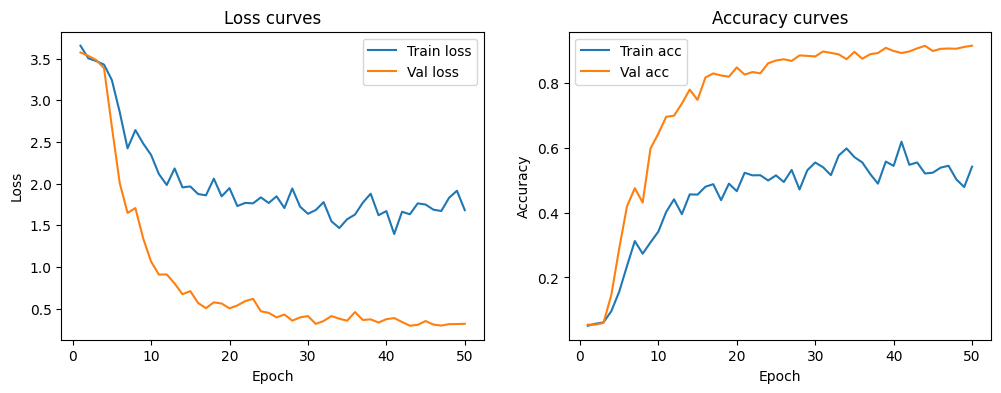

Test metrics: {'test_accuracy': 0.9171021377672209, 'test_balanced_accuracy': np.float64(0.8613501122421747)}
Number of misclassified test samples: 1047

Top-5 predictions for each misclassified image:

Test sample index 16
  True class: 21 (Double curve)
  Predicted: 11 (Right-of-way at the next intersection)
    #1: 11 (Right-of-way at the next intersection)  prob=0.770
    #2: 21 (Double curve)  prob=0.100
    #3: 30 (Beware of ice/snow)  prob=0.092
    #4: 23 (Slippery road)  prob=0.034
    #5: 20 (Dangerous curve to the right)  prob=0.002

Test sample index 30
  True class: 5 (Speed limit (80km/h))
  Predicted: 3 (Speed limit (60km/h))
    #1:  3 (Speed limit (60km/h))  prob=0.967
    #2:  5 (Speed limit (80km/h))  prob=0.030
    #3:  2 (Speed limit (50km/h))  prob=0.004
    #4:  1 (Speed limit (30km/h))  prob=0.000
    #5:  7 (Speed limit (100km/h))  prob=0.000

Test sample index 49
  True class: 8 (Speed limit (120km/h))
  Predicted: 1 (Speed limit (30km/h))
    #1:  1 (Speed li

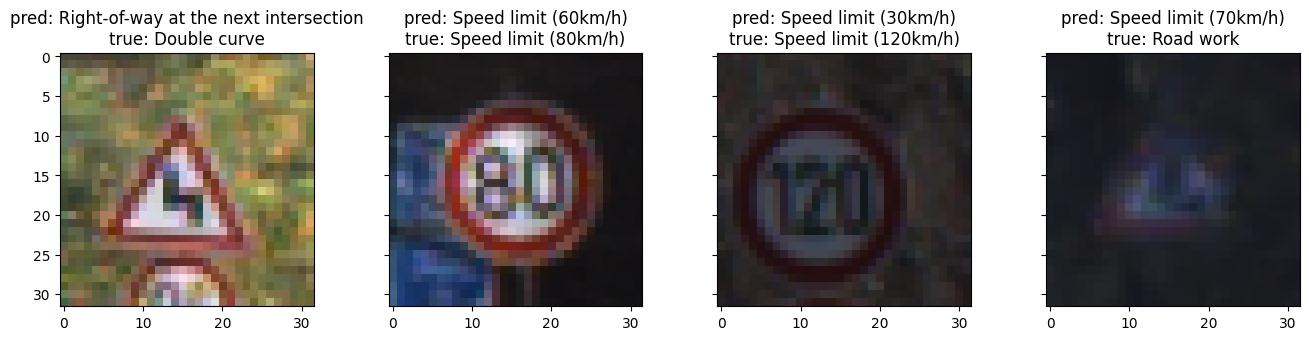

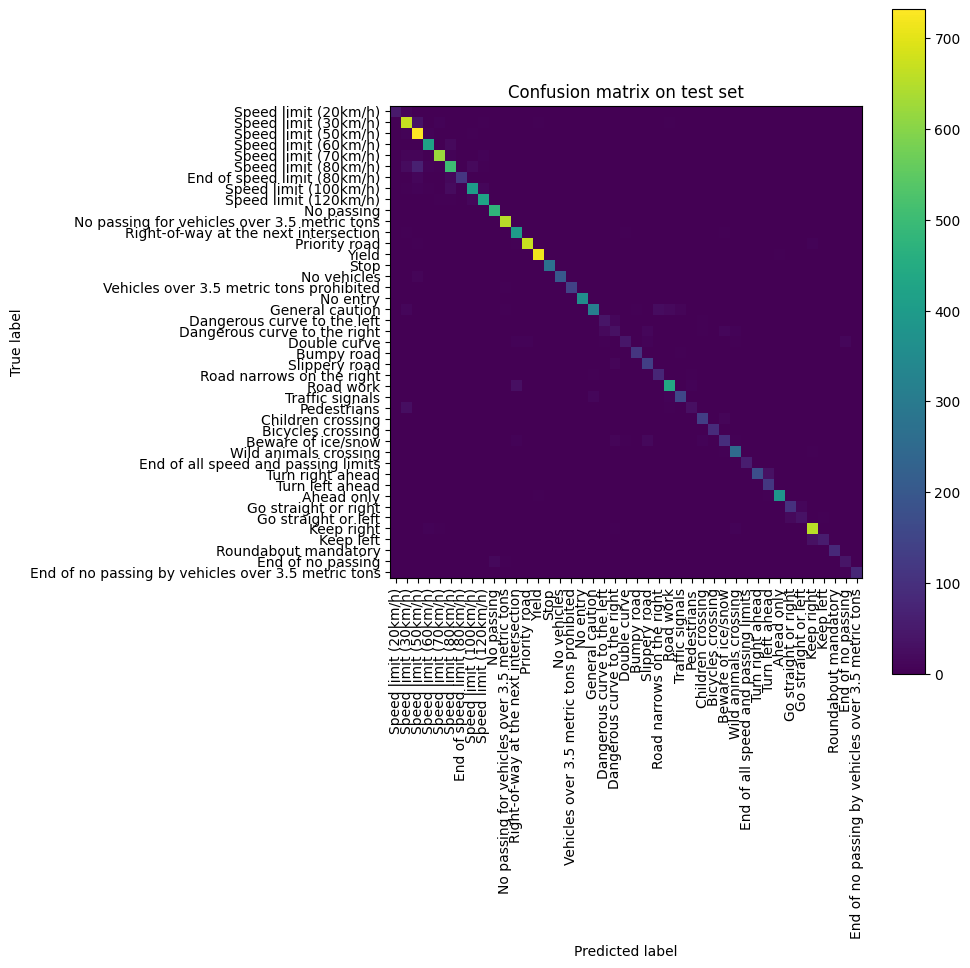

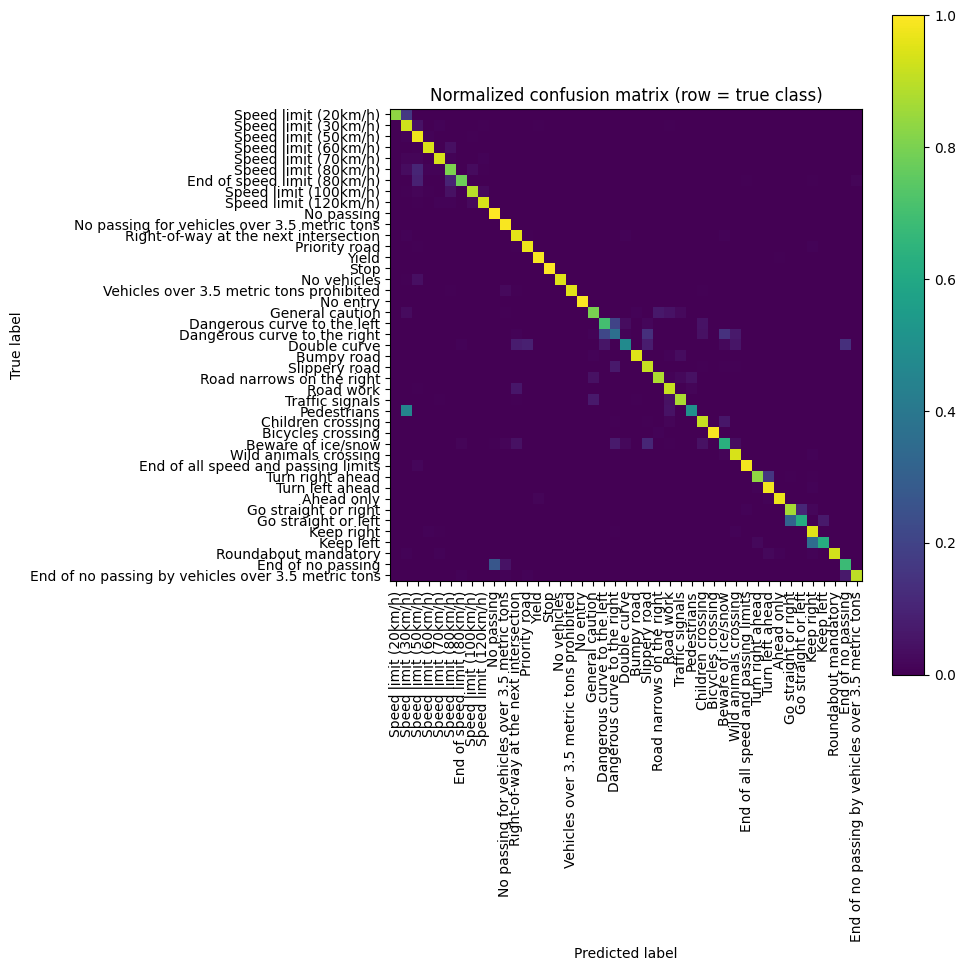


Most frequent misclassifications (true -> predicted, count):
   5 (Speed limit (80km/h)) ->  2 (Speed limit (50km/h)): 64
   1 (Speed limit (30km/h)) ->  2 (Speed limit (50km/h)): 35
  33 (Turn right ahead) -> 34 (Turn left ahead): 33
  39 (Keep left) -> 38 (Keep right): 32
  25 (Road work) -> 11 (Right-of-way at the next intersection): 29
  27 (Pedestrians) ->  1 (Speed limit (30km/h)): 27
  18 (General caution) -> 24 (Road narrows on the right): 25
   5 (Speed limit (80km/h)) ->  1 (Speed limit (30km/h)): 22
   7 (Speed limit (100km/h)) ->  5 (Speed limit (80km/h)): 21
   5 (Speed limit (80km/h)) ->  7 (Speed limit (100km/h)): 19
Saved model weights to conv_classifier_weights.pth
Reloaded model and ready to use on test set.


In [12]:
# Your code goes here
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# --------------------------------------------------
# Device
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------------
# Dataset / Dataloaders
# --------------------------------------------------
class TrafficSignsDataset(Dataset):
    def __init__(self, path):
        images, labels = load_data(path)            # images: (N,32,32,3)
        images = images.transpose((0, 3, 1, 2))     # -> (N,3,32,32)
        self.images = torch.from_numpy(images).float()
        self.labels = torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

batch_size = 256
training_dataset   = TrafficSignsDataset(traffic_signs_dir / "train.p")
validation_dataset = TrafficSignsDataset(traffic_signs_dir / "valid.p")
test_dataset       = TrafficSignsDataset(traffic_signs_dir / "test.p")

training_loader = DataLoader(training_dataset, batch_size=batch_size,
                             shuffle=True,  drop_last=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size,
                               shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, drop_last=False)

# --------------------------------------------------
# Simple tensor-based data augmentation
# (keeps everything on GPU-friendly tensors)
# --------------------------------------------------
def augment(batch_images):
    # batch_images: (B,3,32,32) on device
    # random horizontal flip
    if torch.rand(1).item() < 0.5:
        batch_images = torch.flip(batch_images, dims=[3])

    # random brightness
    if torch.rand(1).item() < 0.5:
        factor = 0.8 + 0.4 * torch.rand(1).item()   # in [0.8,1.2]
        batch_images = torch.clamp(batch_images * factor, 0.0, 255.0)

    # light Gaussian noise
    if torch.rand(1).item() < 0.5:
        noise = torch.randn_like(batch_images) * 2.0
        batch_images = torch.clamp(batch_images + noise, 0.0, 255.0)

    return batch_images

# --------------------------------------------------
# CNN model: feature extractor + 2 Linear layers
# + Dropout for regularization
# --------------------------------------------------
feature_extractor = nn.Sequential(
    nn.Conv2d(3, 24, kernel_size=(6, 6)), nn.ReLU(),
    nn.Conv2d(24, 36, kernel_size=(6, 6)), nn.ReLU(),
    nn.Conv2d(36, 48, kernel_size=(4, 4), stride=2), nn.ReLU(),
    nn.Conv2d(48, 64, kernel_size=(4, 4), stride=2), nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(2, 2), stride=2), nn.ReLU(),
)

conv_classifier = nn.Sequential(
    feature_extractor,          # -> (B, 128, ?, ?)
    nn.Flatten(),               # -> (B,512) as given in the notebook
    nn.Linear(512, 100), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 43),
    nn.Softmax(dim=1),
).to(device)

# --------------------------------------------------
# Helpers: prediction & metrics
# --------------------------------------------------
def predict_batch(model, batch_images, no_grad: bool = True):
    if no_grad:
        with torch.no_grad():
            class_probs = model(batch_images)
    else:
        class_probs = model(batch_images)
    class_labels = torch.argmax(class_probs, dim=1)
    return class_probs, class_labels

def eval_metrics(pred_labels, true_labels, prefix):
    metrics = {
        f"{prefix}accuracy": accuracy_score,
        f"{prefix}balanced_accuracy": balanced_accuracy_score,
    }
    return {name: fn(true_labels, pred_labels) for name, fn in metrics.items()}

# --------------------------------------------------
# Training loop (with augmentation and learning curves)
# --------------------------------------------------
def train_model(model, training_loader, validation_loader,
                num_epochs, learning_rate):

    model.to(device)
    loss_function = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=0.9,
                                weight_decay=1e-4)

    history = {
        "train_loss": [], "val_loss": [],
        "train_accuracy": [], "val_accuracy": [],
        "train_balanced_accuracy": [], "val_balanced_accuracy": [],
    }

    pbar = tqdm(range(num_epochs), desc="Epochs")
    for epoch in pbar:
        # ---------- Training ----------
        model.train()
        train_losses = []
        train_true_labels = []
        train_pred_labels = []

        for batch_images, batch_labels in training_loader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # data augmentation
            batch_images = augment(batch_images)

            class_probs, class_labels = predict_batch(model, batch_images, no_grad=False)
            class_log_probs = torch.log(class_probs + 1e-7)
            loss = loss_function(class_log_probs, batch_labels)

            train_losses.append(loss.item())
            train_true_labels.append(batch_labels.cpu().numpy())
            train_pred_labels.append(class_labels.cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_true_all = np.hstack(train_true_labels)
        train_pred_all = np.hstack(train_pred_labels)
        train_metrics = eval_metrics(train_pred_all, train_true_all, prefix="train_")
        train_loss_mean = np.mean(train_losses)

        # ---------- Validation ----------
        model.eval()
        val_losses = []
        val_true_labels = []
        val_pred_labels = []

        with torch.no_grad():
            for batch_images, batch_labels in validation_loader:
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)

                class_probs, class_labels = predict_batch(model, batch_images, no_grad=True)
                class_log_probs = torch.log(class_probs + 1e-7)
                loss = loss_function(class_log_probs, batch_labels)

                val_losses.append(loss.item())
                val_true_labels.append(batch_labels.cpu().numpy())
                val_pred_labels.append(class_labels.cpu().numpy())

        val_true_all = np.hstack(val_true_labels)
        val_pred_all = np.hstack(val_pred_labels)
        val_metrics = eval_metrics(val_pred_all, val_true_all, prefix="val_")
        val_loss_mean = np.mean(val_losses)

        # store history
        history["train_loss"].append(train_loss_mean)
        history["val_loss"].append(val_loss_mean)
        history["train_accuracy"].append(train_metrics["train_accuracy"])
        history["train_balanced_accuracy"].append(train_metrics["train_balanced_accuracy"])
        history["val_accuracy"].append(val_metrics["val_accuracy"])
        history["val_balanced_accuracy"].append(val_metrics["val_balanced_accuracy"])

        pbar.set_postfix({
            "train_accuracy": f"{train_metrics['train_accuracy']:.3f}",
            "train_balanced_accuracy": f"{train_metrics['train_balanced_accuracy']:.3f}",
            "train_loss": f"{train_loss_mean:.4f}",
            "val_accuracy": f"{val_metrics['val_accuracy']:.3f}",
            "val_balanced_accuracy": f"{val_metrics['val_balanced_accuracy']:.3f}",
        })

    return history

# --------------------------------------------------
# Train the model
# --------------------------------------------------
num_epochs = 50
learning_rate = 1e-2
history = train_model(conv_classifier, training_loader, validation_loader,
                      num_epochs=num_epochs, learning_rate=learning_rate)

# --------------------------------------------------
# Plot learning curves
# --------------------------------------------------
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves")

plt.subplot(1,2,2)
plt.plot(epochs, history["train_accuracy"], label="Train acc")
plt.plot(epochs, history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy curves")
plt.show()

# --------------------------------------------------
# Evaluate on test set & collect predictions
# --------------------------------------------------
conv_classifier.eval()
all_test_probs = []
all_test_preds = []
all_test_true  = []
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        probs, preds = predict_batch(conv_classifier, batch_images, no_grad=True)
        all_test_probs.append(probs.cpu())
        all_test_preds.append(preds.cpu())
        all_test_true.append(batch_labels.cpu())

all_test_probs = torch.cat(all_test_probs, dim=0)          # (N_test, 43)
all_test_preds = torch.cat(all_test_preds, dim=0).numpy()  # (N_test,)
all_test_true  = torch.cat(all_test_true,  dim=0).numpy()  # (N_test,)

test_metrics = eval_metrics(all_test_preds, all_test_true, prefix="test_")
print("Test metrics:", test_metrics)

# --------------------------------------------------
# 1. Show 5 misclassified test samples + top-5 classes
# --------------------------------------------------
# Load class names once
signnames = np.genfromtxt(traffic_signs_dir / "signnames.csv",
                          delimiter=",", dtype=None, encoding=None, names=True)
sign_names = np.array([row["SignName"] for row in signnames])

mis_idx = np.where(all_test_preds != all_test_true)[0]
print("Number of misclassified test samples:", len(mis_idx))

if len(mis_idx) > 0:
    sample_idx = mis_idx[:5]
    images, _ = load_data(traffic_signs_dir / "test.p")  # original (N,32,32,3)
    sample_images = images[sample_idx]                   # (5,32,32,3)

    # top-5 predictions
    sample_probs = all_test_probs[sample_idx]            # (5,43)
    top5_probs, top5_indices = torch.topk(sample_probs, k=5, dim=1)

    print("\nTop-5 predictions for each misclassified image:")
    for i, idx in enumerate(sample_idx):
        true_id = int(all_test_true[idx])
        pred_id = int(all_test_preds[idx])
        print(f"\nTest sample index {idx}")
        print(f"  True class: {true_id} ({sign_names[true_id]})")
        print(f"  Predicted: {pred_id} ({sign_names[pred_id]})")
        for k in range(5):
            cls = int(top5_indices[i, k])
            prob = float(top5_probs[i, k])
            print(f"    #{k+1}: {cls:2d} ({sign_names[cls]})  prob={prob:.3f}")

    # visualize (uses your helper)
    pred_labels_str = np.array([
        f"pred: {sign_names[all_test_preds[i]]}\ntrue: {sign_names[all_test_true[i]]}"
        for i in sample_idx
    ])
    show_image_grid(sample_images, pred_labels_str)


# --------------------------------------------------
# 2. Confusion matrix (on test set) + most common mistakes
# --------------------------------------------------
cm = confusion_matrix(all_test_true, all_test_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sign_names)
disp.plot(ax=ax, include_values=False, xticks_rotation=90, colorbar=True)
plt.title("Confusion matrix on test set")
plt.tight_layout()
plt.show()

# Normalized confusion matrix (per true class)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                              display_labels=sign_names)
disp.plot(ax=ax, include_values=False, xticks_rotation=90, colorbar=True)
plt.title("Normalized confusion matrix (row = true class)")
plt.tight_layout()
plt.show()

# Print the most common confusions (off-diagonal)
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)
pairs = np.dstack(np.unravel_index(np.argsort(cm_off.ravel())[::-1], cm_off.shape))[0]
print("\nMost frequent misclassifications (true -> predicted, count):")
for (i, j) in pairs[:10]:
    if cm_off[i, j] == 0:
        break
    print(f"  {i:2d} ({sign_names[i]}) -> {j:2d} ({sign_names[j]}): {cm_off[i,j]}")


# --------------------------------------------------
# Save + reload model weights example
# --------------------------------------------------
model_path = "conv_classifier_weights.pth"
torch.save(conv_classifier.state_dict(), model_path)
print(f"Saved model weights to {model_path}")

# Example reload (for submission cell)
reloaded_model = nn.Sequential(
    feature_extractor,
    nn.Flatten(),
    nn.Linear(512, 100), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 43),
    nn.Softmax(dim=1),
).to(device)

reloaded_model.load_state_dict(torch.load(model_path, map_location=device))
reloaded_model.eval()
print("Reloaded model and ready to use on test set.")



## Assignment (Part two - Fine-tuning)

Now that we have successfully built our own CNN, we made a good image classification model, but we can still make it better. Moreover, for the perception module of an autonomous vehicle, the application we are aiming for is not classification, but detection. We don't want to classify every frame 'seen' by our vehicle, but we want to detect important objects around us, like cars or traffic lights.

We will use the state of the art by importing a pre-trained YOLO model, and fine-tune it on a CARLA dataset.

Let's start by using the model directly off-the-shelf and see how it performs.

In [13]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,091,712 parameters, 0 gradients, 68.0 GFLOPs

WARNING ⚠️ Dataset 'coco8.yaml' images not found, missing path '/content/datasets/coco8/images/val'
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100% ━━━━━━━━━━━━ 25/25 630.2files/s 0.0s
Dataset download success ✅ (0.6s), saved to /content/datasets

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 571.5±369.1 MB/s, size: 54.0 KB)
val: Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4/4 559.3it/s 0.0s
val: New cache created: /content/datas

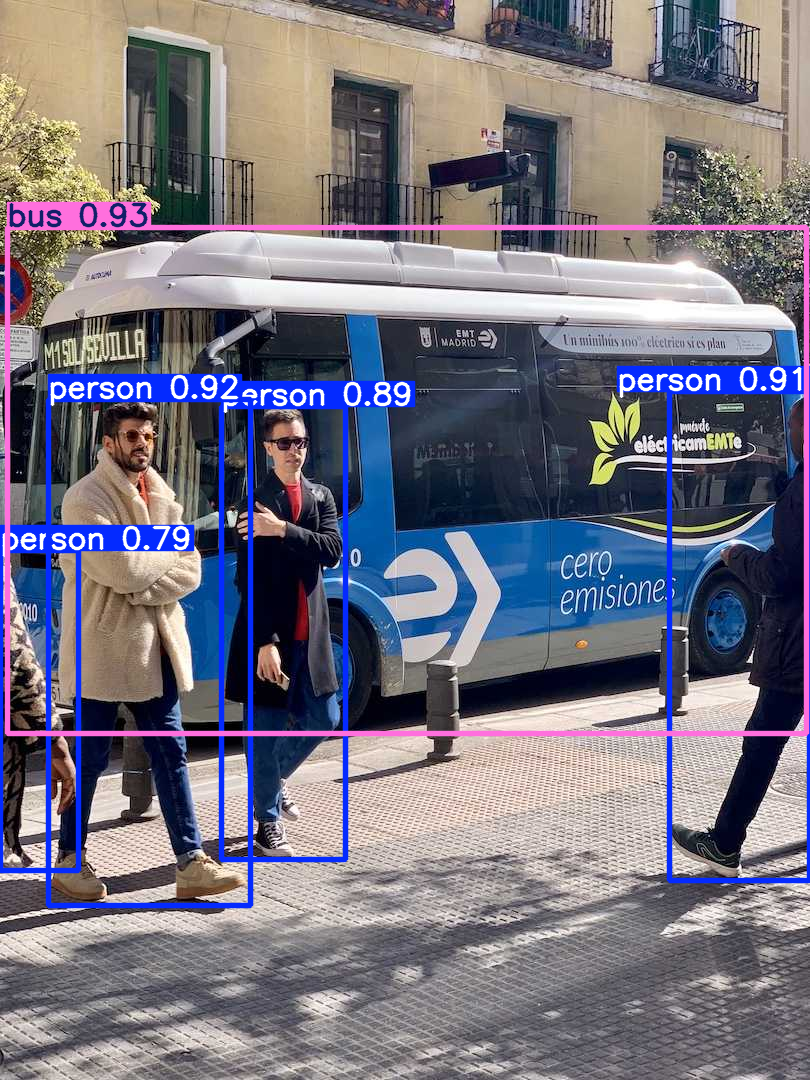

In [14]:
from ultralytics import YOLO

# Load a pretrained YOLO model
model = YOLO("yolo11m.pt")
# There are 5 different versions of YOLO11 which we can use, from n to x. Yolo11n is smaller and faster, but also less precise.
# Yolo11x is bigger and more powerful, but also more ressource expensive.
#   -yolo11n
#   -yolo11s
#   -yolo11m
#   -yolo11l
#   -yolo11x
# yolo11m is a good compromise between speed and precision.

# Evaluate the model's performance on the validation set
results = model.val(data="coco8.yaml")

# Perform object detection on an image using the model
results = model("https://ultralytics.com/images/bus.jpg")

#Here are a few useful methods to get the results of your model.
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen


- Try importing some of the other YOLO models in the cell above. What changes in the output can you see between different versions ?
- **Answer:** I noticed that the smaller ones like yolov8n and yolov8s run much faster but are a bit less accurate. They sometimes miss small objects or give slightly off bounding boxes. On the other hand, larger models like yolov8l and especially yolov8x give more accurate detections, tighter boxes, and more consistent results, but they take longer to run and use more memory.
- How many parameters are there in Yolo11n ? Yolo11x ?
- **Answer:** - yolov8n has about 3.2 million parameters. - yolov8x has about 68.2 million parameters.

The pre-trained YOLO11 model was trained on the COCO dataset containing real images, which reduce its performance when applied to our simulation scenario. To improve it, we want to fine-tune it on a CARLA dataset.

Moreover, the YOLO11 model that we are using is trained on 80 different classes. Some of them are very useful for us like detecting cars, bus and traffic lights but some are not relevant for us. Most importantly, there are classes which we want to detect that are not present in the original dataset used to train YOLO, like traffic light colors !

For our autonmous driving application, we need a dataset containing images collected in the CARLA simulation environment but also labels that reflect the specific things we need to detect.

You can find our custom dataset at : https://app.roboflow.com/carla-test/modified-carla/3

Download the last version in the YOLO11 format and upload the zip file to your google collab notebook.

In [15]:
!unzip "/content/Modified CARLA.v3i.yolov11.zip" -d /content/datasets

Streaming output truncated to the last 5000 lines.
 extracting: /content/datasets/train/images/Town03_017640_png.rf.cb6cd02bcfe447cc0e9c6f8d8b1d1783.jpg  
 extracting: /content/datasets/train/images/Town03_017660_png.rf.2ff86b9537f2561bf59e25962b1b2640.jpg  
 extracting: /content/datasets/train/images/Town03_017660_png.rf.42abf71bce54b30b28f69873299fdbe5.jpg  
 extracting: /content/datasets/train/images/Town03_017660_png.rf.7fbfc254de87eb8fc4da7363304a3e71.jpg  
 extracting: /content/datasets/train/images/Town03_017680_png.rf.56af4dbdd2069f9c41f251f3d8dc49cd.jpg  
 extracting: /content/datasets/train/images/Town03_017680_png.rf.ac7ce4bc86eab1209c38eb7b935cdac5.jpg  
 extracting: /content/datasets/train/images/Town03_017680_png.rf.ad1032c05e3c731007fd73af7eb2f54f.jpg  
 extracting: /content/datasets/train/images/Town03_017740_png.rf.0187f29f2d259f5d58e276541f97fee4.jpg  
 extracting: /content/datasets/train/images/Town03_017740_png.rf.39d8abab60f1f942e27692907cc7f203.jpg  
 extracting: 

- What do you notice about the label distribution ?
- **Answer:** The label distribution is quite unbalanced. Some classes, like cars or traffic signs, appear a lot more than others like pedestrians or bikes. A few classes might have very few examples.
- In you opinion, could this be an issue for our application ?
- **Answer:** Yes, it could be. If some classes are underrepresented, the model might not learn to detect them well. That’s a problem, especially in safety-critical tasks like autonomous driving where every object matters.

Now we train the model on our traffic light dataset

In [16]:
#Save path to our dataset. If nothing is specified, utltralytics loads the coco8 dataset
path = "datasets/data.yaml"

# Train the model for a few epochs
results = model.train(data=path, epochs=3, warmup_epochs=0, pretrained=True)

# Evaluate the model's performance on the validation set
results = model.val()

# Perform object detection on an image using the model
results = model("https://ultralytics.com/images/bus.jpg")

# Save the model
success = model.save("./yolo_collab_tuned.pt")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretra

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1080.8±397.2 MB/s, size: 42.8 KB)
train: Scanning /content/datasets/train/labels... 3183 images, 321 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3183/3183 1.2Kit/s 2.6s
train: New cache created: /content/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 398.5±213.4 MB/s, size: 30.4 KB)
val: Scanning /content/datasets/valid/labels... 270 images, 35 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 270/270 892.1it/s 0.3s
val: New cache created: /content/datasets/valid/labels.cache
Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
o

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

        1/3      7.81G      3.133      5.472      3.155         80        640: 0% ──────────── 0/199  8.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


        1/3      7.89G      1.484      2.037      1.562         87        640: 100% ━━━━━━━━━━━━ 199/199 1.6it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.0it/s 8.9s
                   all        270       1709      0.549      0.358      0.311      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

        2/3      8.13G     0.9225     0.8679      1.107         65        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.736      0.412      0.516      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

        3/3      8.12G     0.7956     0.6744      1.098         55        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


        3/3      8.12G     0.8209     0.6623      1.049         42        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.813      0.485      0.576      0.358

3 epochs completed in 0.104 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 40.5MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.6it/s 5.7s
                   all        270       1709      0.813      0.484      0.576      0.357
                  bike         25         

Let's take a closer look at all the information Ultralytics is giving us:

- First, you can see information on the pre-trained model your are using: its architecture, number of layer, parameters...

- The line `Overriding model.yaml nc=80 with nc=8` tells us that we are changing the dimension of the final layer of the model with our dataset. While the base Yolo is trained to detect 80 class, we are only using 8.

- For each Epoch, you can see the training process advance with the varying loss decreasing over time.

- The mAP for each classes as well as the confusion matrix give you very good overview of your performance.

You just trained an existing model on our custom dataset. When running the evaluation, Ultralytics provides you with a lot of different metrics in the prompt, and even more which you can find in `run/detect/val_`

In [17]:
!pip install ultralytics

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=Fal

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1128.7±332.0 MB/s, size: 42.8 KB)
train: Scanning /content/datasets/train/labels.cache... 3183 images, 321 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3183/3183 4.2Mit/s 0.0s
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.7±1.6 ms, read: 295.8±97.7 MB/s, size: 30.4 KB)
val: Scanning /content/datasets/valid/labels.cache... 270 images, 35 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 270/270 63.2Kit/s 0.0s
Plotting labels to /content/runs/detect/train2/labels.jpg... 
optimizer: SGD(lr=0.002, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/runs/detect/train2
Starting training for 50 

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       1/50      7.93G      1.047      1.984      1.215         87        640: 100% ━━━━━━━━━━━━ 199/199 1.7it/s 1:60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.2it/s 4.1s
                   all        270       1709      0.754      0.463        0.5      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       2/50      7.99G     0.8112      0.842      1.043         65        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 3.9s
                   all        270       1709       0.61      0.575      0.616       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       3/50      8.01G     0.7937     0.6662      1.022         42        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 4.0s
                   all        270       1709      0.629      0.647      0.662      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       4/50      8.04G      0.752     0.5948      1.004         99        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 3.9s
                   all        270       1709      0.847      0.601      0.717       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       5/50      8.04G     0.7447     0.5497     0.9863         84        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.805      0.694       0.76      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       6/50      7.97G     0.6902     0.5035     0.9774         72        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.2it/s 4.0s
                   all        270       1709      0.842      0.689      0.784      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       7/50      8.04G     0.6825     0.4817      0.963         44        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.2it/s 4.1s
                   all        270       1709      0.751      0.717      0.762      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       8/50      8.01G     0.7179     0.4706     0.9695         55        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/50      8.01G     0.6477     0.4606     0.9519         83        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 4.0s
                   all        270       1709      0.835      0.758       0.79       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       9/50      8.03G     0.6417     0.4525     0.9525         60        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 4.0s
                   all        270       1709      0.838      0.726      0.796      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      10/50      7.99G     0.6302     0.4356     0.9424         50        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.797      0.725      0.786      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      11/50      8.01G     0.6186     0.4265     0.9405         44        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.857      0.659      0.758      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      12/50         8G       0.55     0.3844     0.9316         60        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      12/50         8G     0.6071     0.4152     0.9382         54        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.861      0.709      0.768      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      13/50      8.03G     0.5014     0.4121     0.9641         56        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      13/50      8.03G     0.5887     0.4073      0.938         59        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709       0.87      0.756      0.807      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      14/50         8G     0.5793     0.3959     0.9291         60        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.839      0.687      0.772      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      15/50      8.03G     0.5823     0.3942     0.9314         64        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.794      0.728      0.776      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      16/50      8.04G     0.5502     0.3725     0.8366         86        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      16/50      8.04G     0.5655     0.3838     0.9219         66        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.863      0.681      0.777      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      17/50      8.02G     0.4868      0.336     0.8843         64        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      17/50      8.02G     0.5627     0.3753     0.9254         63        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.845      0.746      0.806      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      18/50      7.96G     0.5515     0.3684     0.9136         76        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.927      0.761      0.814      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      19/50      8.01G     0.5355      0.356      0.915         61        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.898       0.75        0.8      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      20/50      8.05G     0.5403     0.3561     0.9133         40        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.854       0.75      0.801       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      21/50      8.02G     0.2973     0.2584     0.8768         28        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      21/50      8.02G     0.5126     0.3448     0.9122         88        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709       0.87      0.794      0.816      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      22/50      7.97G     0.5081     0.3416     0.9073         67        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.907      0.742      0.806      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      23/50      8.01G     0.5001     0.3305     0.9023         73        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.905      0.735      0.794      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      24/50      8.01G     0.5488     0.3733     0.8798         60        640: 0% ──────────── 0/199  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      24/50      8.01G     0.4934     0.3307     0.8984         57        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 3.9s
                   all        270       1709      0.904      0.681      0.769      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      25/50      8.04G     0.4554     0.3251     0.9286         63        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      25/50      8.04G     0.4815     0.3185     0.8943         56        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.2it/s 4.0s
                   all        270       1709      0.868      0.738      0.787      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      26/50      7.97G     0.4923     0.3232     0.8985         48        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 4.0s
                   all        270       1709      0.842      0.756      0.809      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      27/50      8.03G     0.4773      0.316     0.8932         71        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.817      0.739      0.783      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      28/50      8.01G      0.453      0.309     0.8428         70        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      28/50      8.01G     0.4671     0.3089       0.89         57        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.862      0.765      0.809      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      29/50      8.03G     0.4744     0.3365     0.8815         63        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      29/50      8.04G     0.4573     0.3045     0.8884         88        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.7s
                   all        270       1709      0.855      0.737       0.79      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      30/50      7.99G     0.4599     0.3035     0.8862         68        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.7s
                   all        270       1709      0.895      0.743      0.811      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      31/50      8.06G     0.4524     0.2976     0.8905         69        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.877      0.735      0.804      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      32/50      8.03G     0.3952     0.2788     0.9028         56        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      32/50      8.04G     0.4401      0.288     0.8833         57        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.891      0.714      0.791      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      33/50      8.04G     0.4478     0.2736     0.8729         65        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      33/50      8.04G     0.4372     0.2933     0.8832         80        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.852      0.726      0.802      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      34/50      7.99G     0.4421     0.2846     0.8796         76        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.802       0.76        0.8      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      35/50      8.03G     0.4204     0.2774     0.8768         45        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.7s
                   all        270       1709      0.904      0.719      0.808      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      36/50         8G     0.3479     0.2349     0.8758         53        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      36/50      8.01G     0.4262     0.2756     0.8778         57        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.909      0.733      0.819      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      37/50      8.04G     0.3846     0.2479     0.8402         57        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      37/50      8.05G     0.4146     0.2737     0.8738         71        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.7s
                   all        270       1709      0.864      0.746      0.815      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      38/50         8G     0.4129     0.2697     0.8732         54        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.906      0.745      0.812      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      39/50      8.02G     0.4075     0.2669     0.8739         64        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.889      0.736      0.804      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      40/50      8.02G       0.47     0.3062     0.9306         67        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      40/50      8.03G     0.3979     0.2642     0.8706         48        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.938      0.744      0.818      0.574
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      41/50      8.03G     0.4546     0.2476      0.868         36        640: 0% ──────────── 0/199  1.0s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      41/50      8.04G     0.4218      0.259     0.8458         32        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 3.9s
                   all        270       1709      0.851      0.753      0.813      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      42/50      7.96G      0.409     0.2507     0.8425         30        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 4.0s
                   all        270       1709      0.922       0.73      0.808      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      43/50      8.01G     0.3982     0.2451     0.8357         24        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 3.9s
                   all        270       1709      0.934      0.719      0.803      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      44/50         8G     0.3708     0.2186     0.8884         35        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      44/50         8G     0.3925     0.2443     0.8338         20        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 3.9s
                   all        270       1709      0.891      0.729      0.808      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      45/50         8G     0.3651     0.2962     0.8376         25        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      45/50      8.01G     0.3919     0.2409      0.835         23        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 3.9s
                   all        270       1709      0.906      0.714      0.815      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      46/50      7.96G     0.3786     0.2339     0.8334         41        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.3it/s 3.9s
                   all        270       1709      0.921       0.74      0.808      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      47/50      8.02G     0.3757     0.2297      0.831         37        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.887       0.74      0.807      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      48/50      8.02G     0.3864     0.2329     0.8299         61        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      48/50      8.02G     0.3698     0.2273     0.8305         28        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.938      0.727      0.812      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      49/50      8.04G     0.3277     0.2196     0.7945         67        640: 0% ──────────── 0/199  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      49/50      8.05G      0.364     0.2229     0.8291         32        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.932      0.735       0.81       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      50/50      7.97G      0.352     0.2177     0.8257         31        640: 100% ━━━━━━━━━━━━ 199/199 1.8it/s 1:50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.4it/s 3.8s
                   all        270       1709      0.933      0.726      0.809      0.565

50 epochs completed in 1.623 hours.
Optimizer stripped from /content/runs/detect/train2/weights/last.pt, 40.5MB
Optimizer stripped from /content/runs/detect/train2/weights/best.pt, 40.5MB

Validating /content/runs/detect/train2/weights/best.pt...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.4it/s 6.6s
                   all        270       1709      0.937      0.744      0.818      0.573
                  bike         25     

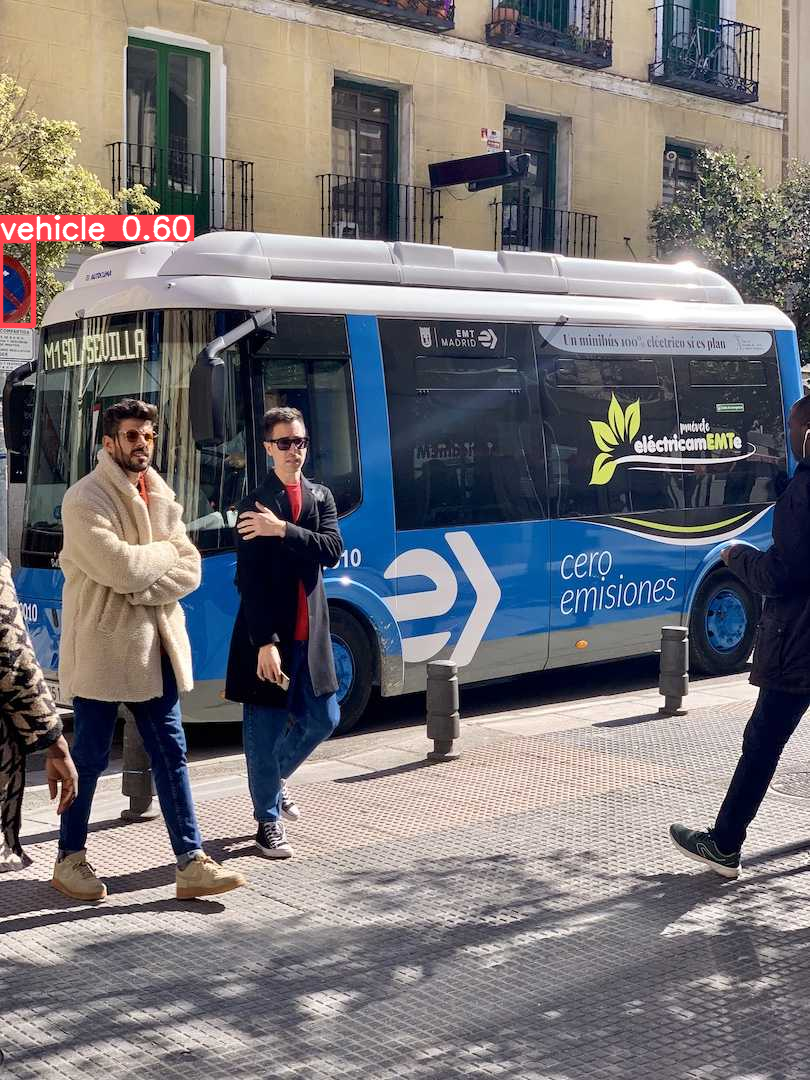

Best model path: /content/runs/detect/train2/weights/best.pt
Last model path: /content/runs/detect/train2/weights/last.pt


In [ ]:
#Put your code here

#Play around the different training parameters of model.train(), add more epochs, and get the best possible model.
#When it starts looking good, import it to CARLA and test it in the simulation !

from ultralytics import YOLO
import torch
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

# Path to our dataset YAML
path = "datasets/data.yaml"

# Reload a fresh model (you can also use your previous best.pt here)
# e.g. YOLO("runs/detect/train/weights/best.pt")
model = YOLO("yolo11m.pt").to(device)

# ---------- TUNED TRAINING RUN ----------
tuned_results = model.train(
    data=path,
    epochs=50,          # more epochs
    imgsz=640,
    batch=16,
    lr0=2e-3,          # slightly smaller LR
    warmup_epochs=2,
    optimizer="SGD",   # or "AdamW"
    patience=15,       # early stopping
    pretrained=True,
)

# ---------- EVALUATE ----------
val_results = model.val(data=path, imgsz=640)
print("mAP50:", val_results.box.map50)
print("mAP50-95:", val_results.box.map)

# ---------- WHERE THE WEIGHTS ARE ----------
run_dir = Path(tuned_results.save_dir)  # e.g. runs/detect/train3
print("Best model path:", run_dir / "weights" / "best.pt")
print("Last model path:", run_dir / "weights" / "last.pt")


When you think the metrics are good enough for your model, you can implement it in CARLA to see if it is able to detect things !
Before running your own model in CARLA, When testing how to properly use a model in the simulation, we recommend using the basic YOLO model to verify that you can detect things. Then, compare it with your own to see which one performs best !

Your model should be saved by ultralytics in `runs/detect/train_/weights` where you have 2 models saved: best.pt and last.pt. The latter is the last version of the model at the end of training, while the former is the best version of the model during training. We recommend you always use best.pt. Download it and put somewhere you can access easily (like `PythonAPI/Modules/model`) as the rest of the module will be on your local machine and the CARLA server.

## Assignment (Part three - Detecting objects in real-time and avoiding them)

Our fine-tuned Yolo model has been training to recognize objects in CARLA. Now, in order to use it properly in the simulation, there are two important steps left, both in python:

- Doing real-time detection of objects
- Using detection results to send commands to the car.

# Real-time detection

Go to `Simulation_Perception.py` and look for the `CameraManager()` class. It is responsible for creating the sensors for the simulation and managing their outputs.
This is where you are going to add your model. Look for the `_parse_image(weak_self, image)` that format and sends the raw image from the Carla sensor and you will find a commented section where you can add your model. The objectiv is to do object detection on these frames, save the results and then draw bounding boxes on it before sending it as usual.

Once complete, run `Simulation_Perception.py` to see your car detecting objects while moving !
don't forget to add the important arguments for the host and the location of your model :
`Python Simulation_Perception.py --host 192.168.54.10 -m model/best.pt`

If you are not satisfyed with the performance of your model in the simulation you can always come back to Part two and try different technique to improve it ! You can always rely on the base YOLO as well, although it will not allow you to detect traffic light color.

# Reacting to detected objects

Now, you will work on creating your Custom agent that react to anything your model detects.

Go to `Custom_agent.py` and look for the main 2 methods you will be working on: `affected_by_traffic_light()` and `affected_by_vehicle`. Their current version is the default CARLA implementation that relies on ground truth simulation information.

Your mission: change the code inside to rely on you detection model instead. You can still use some of the ground truth information, such as the position where the car has to stop for a specific traffic light.
The only condition is that your car must react to outside objects IF AND ONLY IF your model has detected it!
